<h1 align="center">Determinación experimental de la impedancia de un circuito RC paralelo en serie con una resistencia</h1>
<div align="right">David A. Miranda, PhD<br>2023</div>

## 1. Cargar librerías

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd

## 2. Planteamiento del problema

Obtener (a) la curva corriente voltaje y (b) el espectro de impedancia eléctrica para un circuito RC paralelo en serie con una resistencia.

## 3. Métodos y definiciones

In [10]:
dpi = 300

## 4. Adquisición y procesamiento de los datos

### 4.1. Construcción del circuito y conexiones eléctricas

Se construyó un circuito eléctrico con un capacitor $C$ en paralelo con una resistencia, $R_1$ y el circuito resultando en serie con una resistencia $R_2$. Utilice un generador de señales para excitar el circuito y se conectó un terminal del osciloscopio a la fuente de excitación de voltaje $v(t)$ y el otro terminal (referencia), a la resistencia. Se tuvo cuidado en conectar la referencia tanto del generador de señales como del osciloscopio a la resistencia $R_2$.

### 4.2. Curva corriente voltaje

Se excitó el circuito con una señal triangular y capturaron las señales de voltaje del generador de señales $v(t)$ y de la resistencia $R_2$, $v_R(t)$. A continuación, se graficó la corriente que circula por el circuito en función del voltaje de excitación, así como las señales en el tiempo.

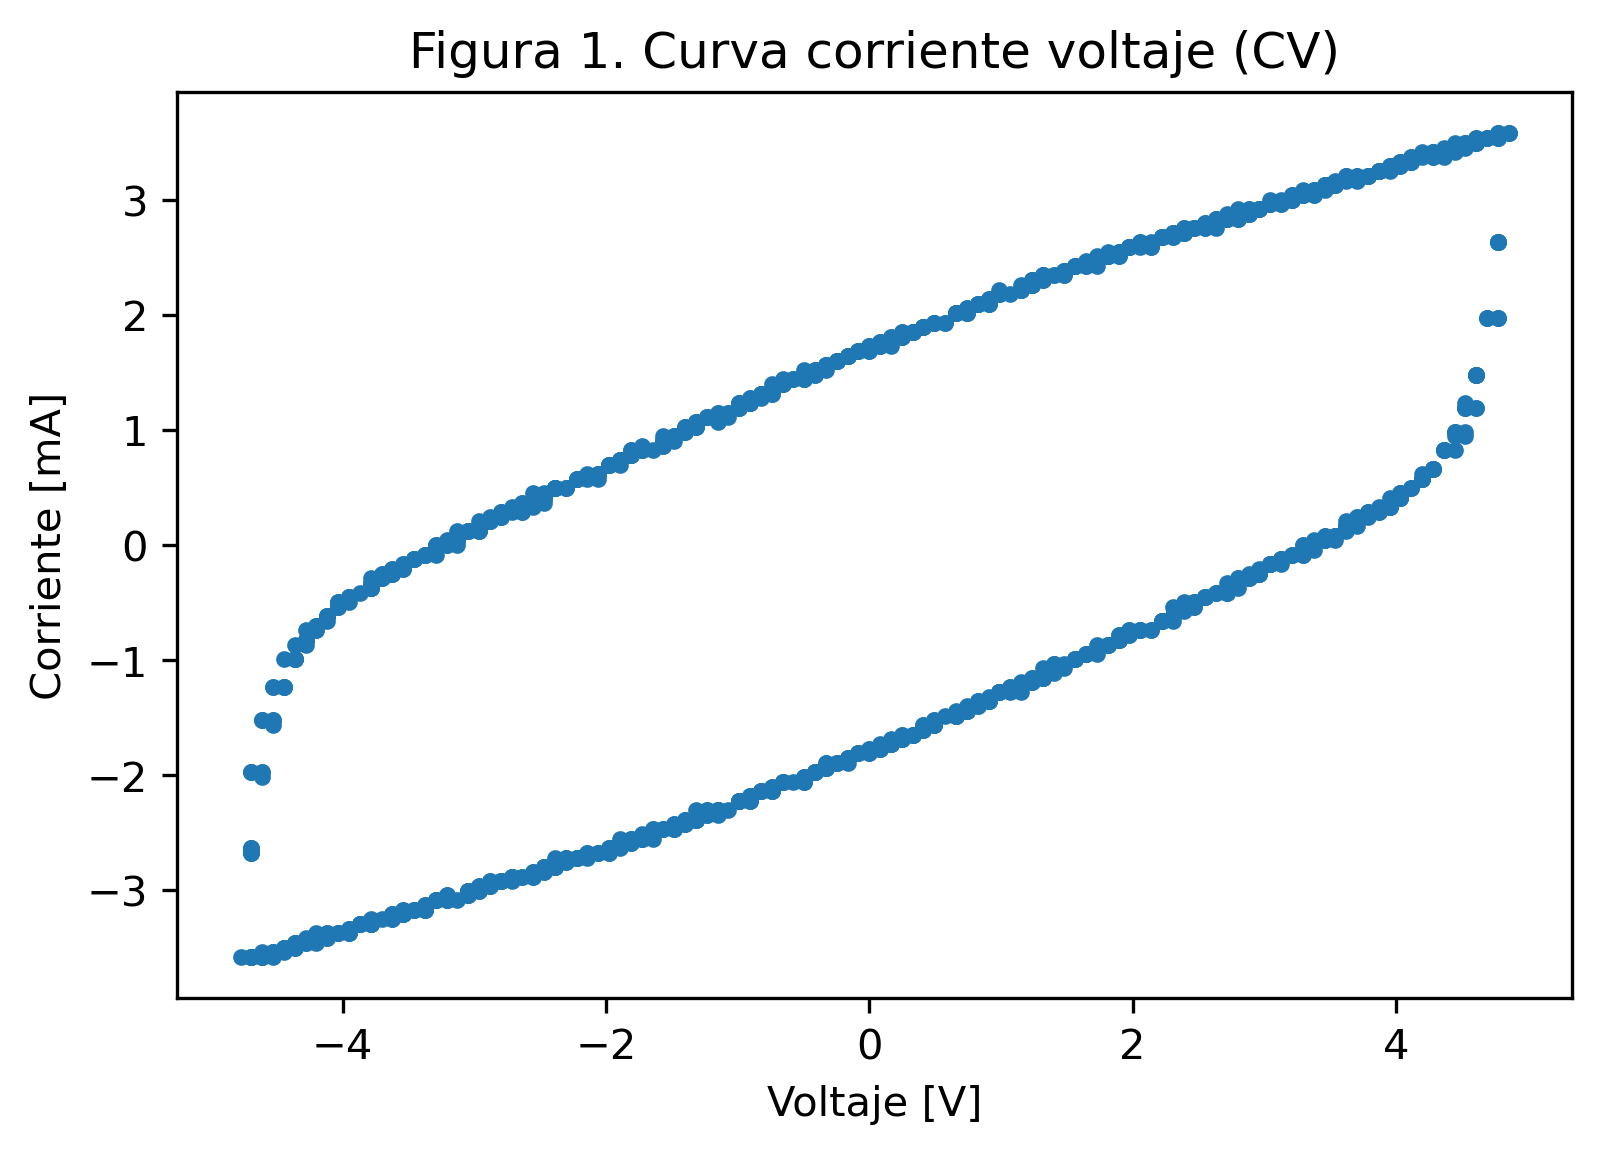

In [27]:
R2 = 100 # Ohm

cv_data = pd.read_csv('../data/CircuitoDummy_ExcitacionTriangular_1kHz.csv', 
                        skiprows=20)
t = 1e-6 * cv_data['Timestamps (ns)'].to_numpy()
v = cv_data['1'].to_numpy()
i = cv_data['2'].to_numpy()/R2

plt.figure(dpi=dpi)
plt.plot(v, 1000*i, '.')
plt.xlabel('Voltaje [V]')
plt.ylabel('Corriente [mA]')
_ = plt.title('Figura 1. Curva corriente voltaje (CV)')

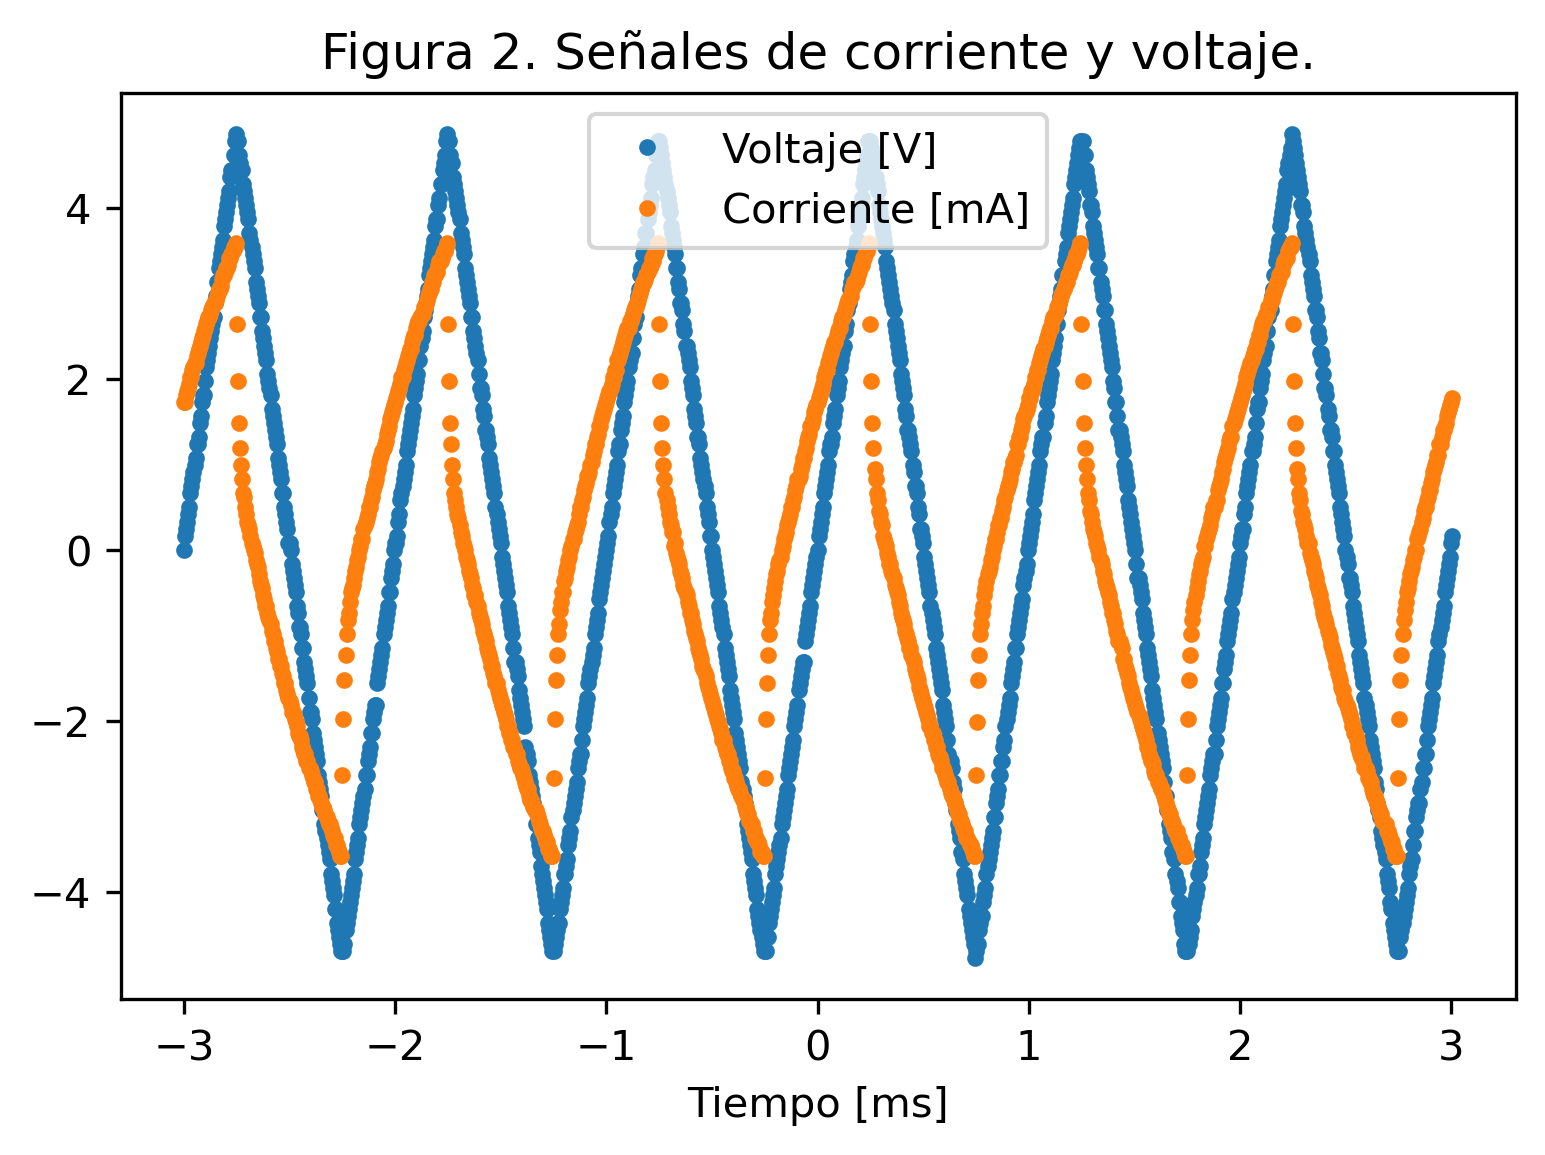

In [26]:
plt.figure(dpi=dpi)
plt.plot(t, v, '.', label='Voltaje [V]')
plt.plot(t, 1000*i, '.', label='Corriente [mA]')
plt.xlabel('Tiempo [ms]')
plt.legend()
_ = plt.title('Figura 2. Señales de corriente y voltaje.')

## 4.3. Espectro de impedancia eléctrica

Se excitó el circuito con una señal sinusoidal y se capturaron las señales de voltaje del generador de señales $v(t)$ y la resistencia $R_2$, $v_R(t)$. A continuación, se calculó la parte real $Z'$ e imaginaria $Z''$ de la impedancia eléctrica y se realizaron las gráficas correspondientes.

In [ ]:
data_list = [
    ['Frecuencia [Hz]', 'V1 [mV]', 'V2 [mV]', 'Δt [µs]'],
    [   100,     ,     , 153.64],
    [   359,     ,     , 194.42],
    [   500,     ,     , 200.86],
    [  1000,     ,     , 153.64],
    [  1291,     ,     , 195.16],
    [  4691,     ,     ,  35.35],
    [ 16681,     ,     ,   7.38],
    [ 59948,     ,     ,   0.88],
    [215553,     ,     ,   0.06],
]
eis_data = pd.DataFrame(data_list[1:], columns=data_list[0])
eis_data['φ [º]'] = (180/np.pi) * 1e-6 * eis_data['Δt [µs]'] * eis_data['Frecuencia [Hz]']
Z = eis_data['Δv [mV]']

## 5. Preguntas de autoexplicación

### 5.1. Primer bloque de preguntas



### 5.2. Segundo bloque de preguntas

En el experimento para obtener la curva corriente voltaje: 

5.2.1. ¿Cómo se obtiene el valor de la corriente que circula por el circuito?

5.2.2. ¿Cuál es el efecto de variar la frecuencia de la señal triangular?

## 5.3. Tercer bloque de preguntas

En el experimento para obtener el espectro de impedancia eléctrica:

5.3.1. Obtenga más datos para que el espectro quede mejor representado.

5.3.2. ¿Cómo se calculó la parte real $Z'$ y la imaginaria $Z''$ de la impedancia eléctrica?

End!